<a href="https://colab.research.google.com/github/kschoi93/AI/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
data_path = '/content/drive/MyDrive/080289-main/080289-main/chap05/data/catanddog/train'

transform = transforms.Compose(
    [ transforms.Resize([256,256]),
      transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

print(len(train_dataset))

385


In [3]:
!pip install mxnet

     |████████████████████████████████| 47.3 MB 1.5 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


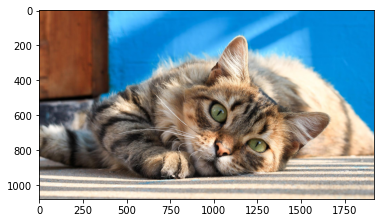

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet.gluon.data.vision import transforms

example_image = mx.image.imread('/content/drive/MyDrive/080289-main/080289-main/chap05/data/cat.jpg')
plt.imshow(example_image.asnumpy())

In [5]:
def show_images(imgs, num_rows, num_cols, scale=2):
  aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1]
  figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  for i in range(num_rows):
      for j in range(num_cols):
          axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
          axes[i][j].axes.get_xaxis().set_visible(False)
          axes[i][j].axes.get_yaxis().set_visible(False)
  plt.subplots_adjust(hspace=0.1, wspace=0)
  return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)


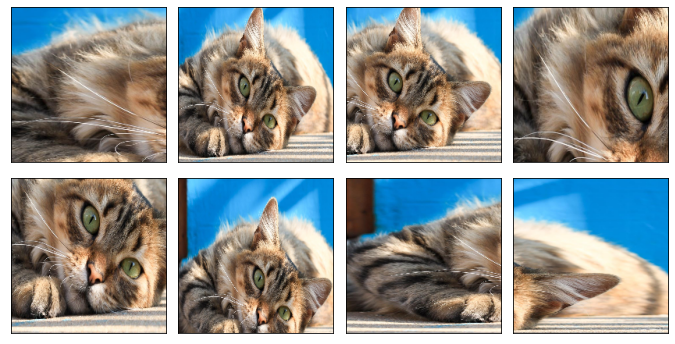

In [6]:
shape_aug = transforms.RandomResizedCrop(size=(200,200), scale=(0.1, 1), ratio=(0.5,2))
apply(example_image,shape_aug)

torch.Size([32, 3, 224, 224])


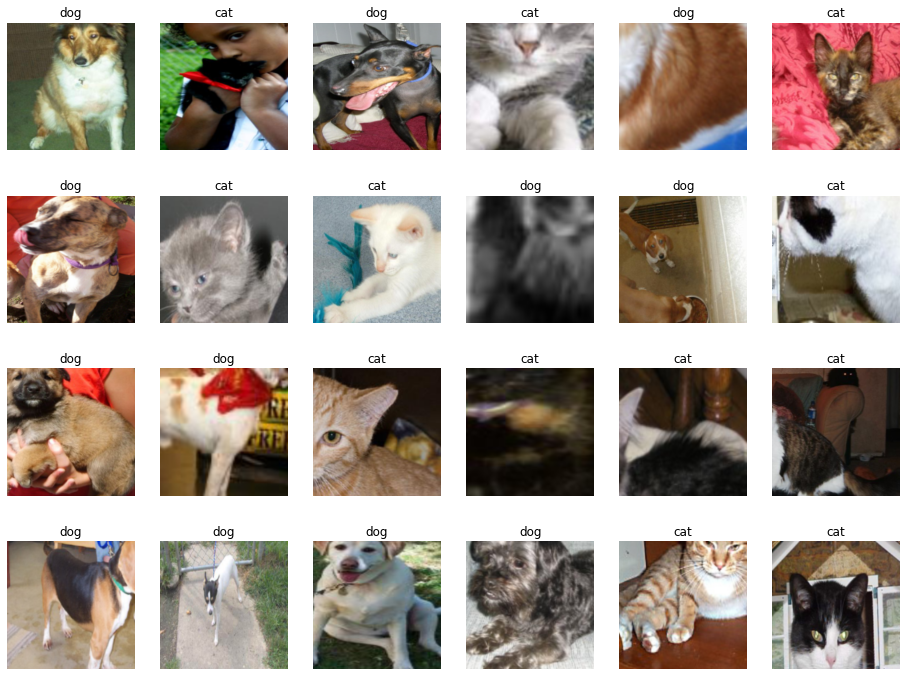

In [7]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
print(samples.shape)

In [8]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [10]:
resnet18.fc = nn.Linear(512,2)


In [11]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0055,  0.0275, -0.0190,  ..., -0.0148,  0.0134,  0.0044],
        [ 0.0205, -0.0120, -0.0082,  ...,  0.0050,  0.0280, -0.0370]])
fc.bias tensor([-0.0417,  0.0380])


In [12]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/080289-main/080289-main/chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [14]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6631 Acc: 0.6130

Epoch 1/12
----------
Loss: 0.4098 Acc: 0.8286

Epoch 2/12
----------
Loss: 0.3726 Acc: 0.8390

Epoch 3/12
----------
Loss: 0.3019 Acc: 0.8727

Epoch 4/12
----------
Loss: 0.3133 Acc: 0.8571

Epoch 5/12
----------
Loss: 0.2705 Acc: 0.8701

Epoch 6/12
----------
Loss: 0.2793 Acc: 0.8883

Epoch 7/12
----------
Loss: 0.2466 Acc: 0.9013

Epoch 8/12
----------
Loss: 0.3163 Acc: 0.8649

Epoch 9/12
----------
Loss: 0.2124 Acc: 0.9065

Epoch 10/12
----------
Loss: 0.2280 Acc: 0.9065

Epoch 11/12
----------
Loss: 0.1890 Acc: 0.9221

Epoch 12/12
----------
Loss: 0.2296 Acc: 0.9117

Training complete in 27497571m 47s
Best Acc: 0.922078
